In [258]:
# Modify this according to the path in your computer
scenario = '2050_100_2'
main_dir = 'My Drive/Research/2022_FloodsEPA/Results/'
data_dir = 'My Drive/Research/2022_FloodsEPA/Results/'+scenario+'/' # <-- change this to reflect the pathing in your machine

# Top

In [259]:
! pip install geopandas
! pip install geopy
! pip install -U plotly
! pip install cpi


# Import needed packages
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as sts
from scipy.stats import ttest_ind
from numpy.random import default_rng
from plotnine import *
import time
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import plotly.express as px
import cpi

theReferenceYear = 2020
theEquityFlag = 0
rng = default_rng(13)
theAMI = 149907# San Mateo
vir1 = '#440154FF'
vir2 = '#3B528BFF'
vir3 = '#21908CFF'
vir4 = '#5DC863FF'
vir5 = '#FED725FF'


print(px.colors.sequential.Agsunset)
color_sunset_1 = '#4c2991'
color_sunset_2 = '#ce4993'
color_sunset_3 = '#ee5d6c'
color_sunset_4 = '#fb9062'
color_sunset_5 = '#f6aa7a'

['rgb(75, 41, 145)', 'rgb(135, 44, 162)', 'rgb(192, 54, 157)', 'rgb(234, 79, 136)', 'rgb(250, 120, 118)', 'rgb(246, 169, 122)', 'rgb(237, 217, 163)']


In [260]:
df_blds = pd.read_csv(main_dir + 'Buildings.txt',header=0)
df_blds['MortgageEnd'] = df_blds['Mortgage_Date'] + df_blds['Mortgage_Maturity']
df_blds['IncomeTag'] = df_blds['OwnerIncomeToday'].apply(lambda x: 'Very low' if x < 0.5 * theAMI else ('Low' if x < 0.8 * theAMI else ('Moderate' if x < 1.2 * theAMI else 'High')))
df_blds['MortgageTag'] = df_blds['MortgageEnd'].apply(lambda x: 'None' if x - theReferenceYear <= 0  else ('<10' if x -theReferenceYear < 10  else ('<20' if x -theReferenceYear < 20 else '>20')))
df_blds['Equity'] = np.minimum(0.2 + 0.8 * (theReferenceYear - df_blds['Mortgage_Date']) / df_blds['Mortgage_Maturity'],1) * df_blds['HomeValue']
df_blds.head(2)

,Latitude,Longitude,FloodPlain,Mortgage_Date,Mortgage_Maturity,HomeValue,OwnerIncomeToday,MortgageEnd,IncomeTag,MortgageTag,Equity
0,37.474263,-122.153298,Yes,2008,30,377565.570382,175012.968839,2038,Moderate,<20,196334.096599
1,37.474234,-122.153097,Yes,2012,30,223821.548847,39760.901335,2042,Very low,>20,92512.906857


## Losses

### Real estate

In [261]:
df_realestate = pd.read_csv(data_dir + 'RealEstate.csv',header=None).multiply(cpi.inflate(1,2017,to=theReferenceYear))
df_realestate.columns = ['S'+str(i) for i in range(df_realestate.shape[1])]
df_realestate = df_realestate.loc[:,'S0':'S999']

In [262]:
print('count:',np.nanmedian(df_realestate.replace(0,np.nan).count()))
print('median:',np.nanmedian(df_realestate.replace(0,np.nan).median(axis=0)))
print('mean:',np.nanmean(df_realestate.replace(0,np.nan).median(axis=0)))

count: 862.0
median: 92000.79307459001
mean: 94526.14490327788


### Contents

In [263]:
df_contents = pd.read_csv(data_dir + 'Contents.csv',header=None).multiply(cpi.inflate(1,2017,to=theReferenceYear))
df_contents.columns = ['S'+str(i) for i in range(df_contents.shape[1])]
df_contents.head(3)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S990,S991,S992,S993,S994,S995,S996,S997,S998,S999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
df_dmgs = df_realestate #+ df_contents
df_dmgs.head(3)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S990,S991,S992,S993,S994,S995,S996,S997,S998,S999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Insurance

In [265]:
def getInsuranceAmount():

    # Insurance penetration
    v = []
    for i in range(df_blds.shape[0]):

        # If in the 100-year flood plain
        if df_blds.loc[i,'FloodPlain'] == 'Yes':
            ins_prob = 0.38
            is_insured = 1 if rng.random() < ins_prob else 0
            v.append(is_insured)

        else:
            ins_prob = 0.028
            is_insured = 1 if rng.random() < ins_prob else 0
            v.append(is_insured)

    # Deductible
    a_deductibles = [500,1000,1250,1500,2000,3000,4000,5000,10000]
    p_deductibles = [0.89,12.09,6.69,0.06,28.53,1.92,1.35,45.45,3.02]
    p_deductibles = [i/sum(p_deductibles) for i in p_deductibles]
    deductibles = rng.choice(a=a_deductibles,p=p_deductibles,size=len(df_blds.index),replace=True)


    # Amount from insurance
    df_ins = df_dmgs.copy()
    for c in df_ins.columns:

        df_ins[c] = np.minimum(np.maximum((df_dmgs[c] - deductibles) * v,0),250000)

    return df_ins


df_ins = getInsuranceAmount()

## FEMA

In [266]:
def getFEMAApproval(FVL,income,insurance):

    if FVL < 5000:

        if income == 'Very low' and insurance == False:
            return 0.527
        elif income == 'Very low' and insurance == True:
            return 0.294
        elif income == 'Low' and insurance == False:
            return 0.523
        elif income == 'Low' and insurance == True:
            return 0.290
        elif income == 'Moderate' and insurance == False:
            return 0.519
        elif income == 'Moderate' and insurance == True:
            return 0.297
        elif income == 'High' and insurance == False:
            return 0.518
        elif income == 'High' and insurance == True:
            return 0.303

    else:
        if income == 'Very low' and insurance == False:
            return 0.838 - FVL * 3.3*1/np.power(10,6)
        elif income == 'Very low' and insurance == True:
            return 0.577 - FVL * 2.8*1/np.power(10,6)
        elif income == 'Low' and insurance == False:
            return 0.829 - FVL * 3.3*1/np.power(10,6)
        elif income == 'Low' and insurance == True:
            return 0.556 - FVL * 4.2*1/np.power(10,6)
        elif income == 'Moderate' and insurance == False:
            return 0.799 - FVL * 1.9*1/np.power(10,6)
        elif income == 'Moderate' and insurance == True:
            return 0.541 - FVL * 3.8*1/np.power(10,6)
        elif income == 'High' and insurance == False:
            return 0.756 - FVL * 7.9*1/np.power(10,6)
        elif income == 'High' and insurance == True:
            return 0.481 - FVL * 3.9*1/np.power(10,6)


def getFEMAAmount(FVL,income,insurance):
    theFEMACap = 36000 #in 2020 https://www.federalregister.gov/documents/2020/11/02/2020-24235/notice-of-maximum-amount-of-assistance-under-the-individuals-and-households-program
    theAmount = 0

    if FVL > 0:
        if income == 'High' and insurance == True:
            theAmount = FVL**2 * -7.72*1/np.power(10,6) + 0.786 * FVL + 10385
        elif income != 'High' and insurance == True:
            theAmount = FVL**2 * -8.41*1/np.power(10,6) + 0.877 * FVL + 8335
        elif insurance == False:
            theAmount = FVL**2 * -1.47*1/np.power(10,5) + 1.223 * FVL + 6201
    return np.minimum(theAmount,theFEMACap)

## SBA

In [267]:
r = 0.02/12
n = 27*12
income = 175012.968839
0.24 * (income/12) * ((1+r)**n - 1) / (r * (1 + r)**n)

875743.3548615542

In [268]:
def getSBALoan(income,equity,mortgage,loss,balance):

    sba_amt = 0
    sba_cap = 500000.0
    anticipated_loan = 0.4692 * loss + 1891.9 # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3839044

    sba_amt = min(balance,anticipated_loan,sba_cap)

    return sba_amt

## Bank

In [269]:
def getBankLoan(income,equity,loss,balance):

    bank_loan_maturity = 30.0
    bank_gdsr = 0.33
    bank_min = 0

    # Calculate the maximum loan amount
    # We use the mortgage equation to calculate P, the loan amount
    # M = P * r * (1 + r)**n / ((1+r)**n - 1)
    r = 0.08 / 12 # monthly interest rate at the last year in the dataframe
    n = bank_loan_maturity * 12 # maturity [months]
    P = bank_gdsr * (income/12) * ((1+r)**n - 1) / (r * (1 + r)**n)
    bank_amt = min(balance,P,max(equity - loss,0))

    return bank_amt

# No Major Disaster Declaration

## SBA

In [270]:
df_SBA = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999'])

for i in range(len(df_SBA.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_SBA.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity']
        mortgage = df_blds.loc[i,'MortgageEnd'] > 2020
        if balance > 0 and equity > 0:
            df_SBA.iloc[i,j] = getSBALoan(income,equity,mortgage,loss,balance)

## Bank

In [271]:
df_bank = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])

for i in range(len(df_bank.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_bank.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity'] - df_SBA.iloc[i,j]

        if balance > 0 and equity > 0:
            df_bank.iloc[i,j] = getBankLoan(income,equity,loss,balance)

## Financing

In [272]:
df_Financing_ND = pd.DataFrame()
df_Financing_ND['Loss'] = df_dmgs.replace(0,0).sum(axis=0)
df_Financing_ND['UHN'] = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).sum(axis=0)
df_Financing_ND['Loans'] = df_SBA.loc[:,'S0':'S999'].add(df_bank.loc[:,'S0':'S999']).sum(axis=0)

In [273]:
df_summary_ND = pd.DataFrame()
df_summary_ND['Tag'] = df_blds['IncomeTag']
df_summary_ND['Loss'] = df_dmgs['S745']
df_summary_ND['Insurance'] = df_ins['S745']
df_summary_ND['FEMA'] = 0
df_summary_ND['SBA'] = df_SBA['S745']
df_summary_ND['SSGP'] = 0
df_summary_ND['Bank'] = df_bank['S745']
df_summary_ND['CDBGDR'] = 0
df_summary_ND['Unmet'] = df_dmgs['S745'].subtract(df_ins['S745']).subtract(df_SBA['S745']).subtract(df_bank['S745'])

## Debt

In [274]:
r1 = 0.08/12
r2 = 0.0269/12 # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3839044
m1 = 30*12
m2 = 30*12
df_Debt_ND =  df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).multiply(12 * (r1*(r1+1)**m1)/((r1+1)**m1 - 1)) +\
            df_SBA.loc[:,'S0':'S999'].multiply(12 * (r2*(r2+1)**m2)/((r2+1)**m2 - 1)) +\
            df_bank.loc[:,'S0':'S999'].multiply(12 * (r1*(r1+1)**m1)/((r1+1)**m1 - 1))

df_Debt_ND = df_Debt_ND.clip(lower=0)



---



# Major Disaster Declaration

## FEMA

In [275]:
df_FEMA = df_dmgs.clip(upper=0).copy()


UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for j in range(UHN.shape[1]):
    fema = []
    for i in range(UHN.shape[0]):
        income = df_blds.loc[i,'IncomeTag']

        FVL = np.minimum(df_dmgs.iloc[i,j],cpi.inflate(41000,2021,2020))
        insurance = True if df_ins.iloc[i,j] > 0 else False

        fema_amt = 0
        if getFEMAApproval(FVL,income,insurance) > rng.random():
            fema_amt = np.minimum(getFEMAAmount(FVL,income,insurance),UHN.iloc[i,j])
        fema.append(fema_amt)


    df_FEMA[df_FEMA.columns[j]] = fema

## SBA

In [276]:
df_SBA = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for i in range(len(df_SBA.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_SBA.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity']
        mortgage = df_blds.loc[i,'MortgageEnd'] > 2020
        if balance > 0 and equity > 0:
            df_SBA.iloc[i,j] = getSBALoan(income,equity,mortgage,loss,balance)

## SSGP

In [277]:
ssgp_cap = 10000
df_SSGP = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for i in range(len(df_SSGP.index)):
    for j in range(len(df_SSGP.columns)):
        fema_amt = df_FEMA.iloc[i,j]
        sba_amt = df_SBA.iloc[i,j]
        if fema_amt > 0:
            df_SSGP.iloc[i,j] = np.maximum(0,np.minimum(UHN.iloc[i,j],ssgp_cap))

## Bank

In [278]:
df_bank = df_dmgs.clip(upper=0).copy()

UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999'])

for i in range(len(df_bank.index)):
    income = df_blds.loc[i,'OwnerIncomeToday']
    for j in range(len(df_bank.columns)):
        loss = df_dmgs.iloc[i,j]
        balance = UHN.iloc[i,j]
        equity = df_blds.loc[i,'Equity'] - df_SBA.iloc[i,j]

        if balance > 0 and equity > 0:
            df_bank.iloc[i,j] = getBankLoan(income,equity,loss,balance)

## Financing

In [279]:
df_Financing_DD = pd.DataFrame()
df_Financing_DD['Loss'] = df_dmgs.replace(0,0).sum(axis=0)
df_Financing_DD['UHN'] = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999'])\
                        .subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).sum(axis=0)
df_Financing_DD['Loans'] = df_SBA.loc[:,'S0':'S999'].add(df_bank.loc[:,'S0':'S999']).sum(axis=0)

In [280]:
df_summary_DD = pd.DataFrame()
df_summary_DD['Tag'] = df_blds['IncomeTag']
df_summary_DD['Loss'] = df_dmgs['S745']
df_summary_DD['Insurance'] = df_ins['S745']
df_summary_DD['FEMA'] = df_FEMA['S745']
df_summary_DD['SBA'] = df_SBA['S745']
df_summary_DD['SSGP'] = df_SSGP['S745']
df_summary_DD['Bank'] = df_bank['S745']
df_summary_DD['CDBGDR'] = 0
df_summary_DD['Unmet'] = df_dmgs['S745'].subtract(df_ins['S745']).subtract(df_FEMA['S745']).subtract(df_SSGP['S745'])\
                        .subtract(df_SBA['S745']).subtract(df_bank['S745'])

## Debt

In [281]:
r1 = 0.08/12
r2 = 0.0269/12 # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3839044
m1 = 30*12
m2 = 30*12
df_Debt_DD = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])\
            .subtract(df_SSGP.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).multiply(12 * (r1*(r1+1)**m1)/((r1+1)**m1 - 1)) +\
            df_SBA.loc[:,'S0':'S999'].multiply(12 * (r2*(r2+1)**m2)/((r2+1)**m2 - 1)) +\
            df_bank.loc[:,'S0':'S999'].multiply(12 * (r1*(r1+1)**m1)/((r1+1)**m1 - 1))

df_Debt_DD = df_Debt_DD.clip(lower=0)



---

---





# Major Disaster Declaration + CDBGDR

## CDBGDR

In [282]:
cdbgdr_cap = 150000
df_CDBG = df_dmgs.clip(upper=0).copy()
UHN = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999'])\
            .subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999'])
UHN = UHN.clip(lower=0)

for j in range(UHN.shape[1]):
    v = []
    for i in range(UHN.shape[0]):
        if df_blds.loc[i,'IncomeTag'] not in ['High','Moderate']:
            v.append(np.minimum(cdbgdr_cap,UHN.iloc[i,j]))
        else:
            v.append(0)

    df_CDBG[df_CDBG.columns[j]] = v

## Financing

In [283]:
df_Financing_CD = pd.DataFrame()
df_Financing_CD['Loss'] = df_dmgs.replace(0,0).sum(axis=0)
df_Financing_CD['UHN'] = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SSGP.loc[:,'S0':'S999'])\
                        .subtract(df_CDBG.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).sum(axis=0)
df_Financing_CD['Loans'] = df_SBA.loc[:,'S0':'S999'].add(df_bank.loc[:,'S0':'S999']).sum(axis=0)

In [284]:
df_summary_CD = pd.DataFrame()
df_summary_CD['Tag'] = df_blds['IncomeTag']
df_summary_CD['Loss'] = df_dmgs['S745']
df_summary_CD['Insurance'] = df_ins['S745']
df_summary_CD['FEMA'] = df_FEMA['S745']
df_summary_CD['SBA'] = df_SBA['S745']
df_summary_CD['SSGP'] = df_SSGP['S745']
df_summary_CD['Bank'] = df_bank['S745']
df_summary_CD['CDBGDR'] = df_CDBG['S745']
df_summary_CD['Unmet'] = df_dmgs['S745'].subtract(df_ins['S745']).subtract(df_FEMA['S745']).subtract(df_SSGP['S745'])\
                        .subtract(df_CDBG['S745']).subtract(df_SBA['S745']).subtract(df_bank['S745'])

## Debt

In [285]:
r1 = 0.08/12
r2 = 0.0269/12 # https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3839044
m1 = 30*12
m2 = 30*12
df_Debt_CD = df_dmgs.loc[:,'S0':'S999'].subtract(df_ins.loc[:,'S0':'S999']).subtract(df_FEMA.loc[:,'S0':'S999']).subtract(df_SBA.loc[:,'S0':'S999'])\
            .subtract(df_SSGP.loc[:,'S0':'S999']).subtract(df_CDBG.loc[:,'S0':'S999']).subtract(df_bank.loc[:,'S0':'S999']).multiply(12 * (r1*(r1+1)**m1)/((r1+1)**m1 - 1)) +\
            df_SBA.loc[:,'S0':'S999'].multiply(12 * (r2*(r2+1)**m2)/((r2+1)**m2 - 1)) +\
            df_bank.loc[:,'S0':'S999'].multiply(12 * (r1*(r1+1)**m1)/((r1+1)**m1 - 1))

df_Debt_CD = df_Debt_CD.clip(lower=0)

In [286]:
df_Debt_ND.to_csv(main_dir + 'df_Debt_' + scenario + '_ND.txt',index=False)
df_Debt_DD.to_csv(main_dir + 'df_Debt_' + scenario + '_DD.txt',index=False)
df_Debt_CD.to_csv(main_dir + 'df_Debt_' + scenario + '_CD.txt',index=False)



---



---




# Well-being Loss

In [287]:
def getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat):
    # Adapted from Markhvida et al: Quantification of disaster impacts through household well-being losses

    # Inputs
    AMI = theAMI
    eta = 1.5 # elasticity of marginal utility of consumption
    theDiscountRate = 0.1
    theMortgageYears = int(np.round(mtg_mat)) # duration remaining on mortgage
    mtginstallment = mtg_amt
    theLoanMaturity = int(np.round(loan_mat)) # loan maturity
    loanInstallment = loan_amt # annual expenditure with loan payment

    # Consumption
    theC0a = income - mtginstallment # consumption pre-disaster
    theC0b = income  # consumption pre-disaster, if no mortgage
    theC1 = income - mtginstallment - loanInstallment # consumption post disaster, during mortgage
    theC2 = income - loanInstallment # consumption post disaster, post mortgage
    theAMIC = 0.7 * AMI

                          # during mortgage +\ after mortgage
    theLossOfWellBeing = (theC0a**(1-eta) - theC1**(1-eta)) * np.sum([np.exp(-0.1) for i in range(theMortgageYears)]) +\
                        (theC0b**(1-eta) - theC2**(1-eta)) * np.sum([np.exp(-0.1) for i in range(theMortgageYears,theLoanMaturity,1)])

    theLossOfWellBeing /= (1 - eta)

    # The equivalent consumption change represents the dollar amount by which a household earning the mean Area income would have to decrease its consumption
    # to experience the same well-being decrease as the considered household
    theEquivalentLossInConsumption = theAMIC - np.power(-(1 - eta) * theLossOfWellBeing/np.sum([np.exp(-0.1) for i in range(30)]) + theAMIC**(1-eta),1/(1-eta))

    return theEquivalentLossInConsumption

In [288]:
df_ND = pd.merge(df_Debt_ND,df_blds[['OwnerIncomeToday','MortgageEnd']], right_index=True, left_index=True)
df_ND['MortgageEnd'] = df_ND['MortgageEnd'].apply(lambda x: np.maximum(x-theReferenceYear,0))

r = 0.08/12
m = 30*12
for j in range(df_ND.shape[1]-2):
    v = []
    for i in range(df_ND.shape[0]):
        if df_ND.loc[i,'S'+str(j)] > 0:
            income = df_ND.loc[i,'OwnerIncomeToday']
            mtg_amt = 0.3 * income
            mtg_mat = int(df_ND.loc[i,'MortgageEnd'])
            loan_amt = df_ND.loc[i,'S'+str(j)]# * 12 * (r*(r+1)**m)/((r+1)**m - 1)
            loan_mat = 30
            v.append(getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat))
        else:
            v.append(np.nan)

    print(j)
    df_ND['S'+str(j)] = v

0
1
2
3


/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/1010128908.py:21: RuntimeWarning:

invalid value encountered in scalar power

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/1010128908.py:22: RuntimeWarning:

invalid value encountered in scalar power



4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

In [289]:
df_DD = pd.merge(df_Debt_DD,df_blds[['OwnerIncomeToday','MortgageEnd']], right_index=True, left_index=True)
df_DD['MortgageEnd'] = df_DD['MortgageEnd'].apply(lambda x: np.maximum(x-theReferenceYear,0))

r = 0.08/12
m = 12 * 30
for j in range(df_DD.shape[1]-2):
    v = []
    for i in range(df_DD.shape[0]):
        if df_DD.loc[i,'S'+str(j)] > 0:
            income = df_DD.loc[i,'OwnerIncomeToday']
            mtg_amt = 0.3 * income
            mtg_mat = int(df_DD.loc[i,'MortgageEnd'])
            loan_amt = df_DD.loc[i,'S'+str(j)]# * 12 * (r*(r+1)**m)/((r+1)**m - 1)
            loan_mat = 30
            v.append(getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat))
        else:
            v.append(np.nan)

    print(j)
    df_DD['S'+str(j)] = v

0
1
2
3
4


/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/1010128908.py:21: RuntimeWarning:

invalid value encountered in scalar power

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/1010128908.py:22: RuntimeWarning:

invalid value encountered in scalar power



5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


In [290]:
df_CD = pd.merge(df_Debt_CD,df_blds[['OwnerIncomeToday','MortgageEnd']], right_index=True, left_index=True)
df_CD['MortgageEnd'] = df_CD['MortgageEnd'].apply(lambda x: np.maximum(x-theReferenceYear,0))

r = 0.08/12
m = 12 * 30
for j in range(df_CD.shape[1]-2):
    v = []
    for i in range(df_CD.shape[0]):
        if df_CD.loc[i,'S'+str(j)] > 0:
            income = df_CD.loc[i,'OwnerIncomeToday']
            mtg_amt = 0.3 * income
            mtg_mat = int(df_CD.loc[i,'MortgageEnd'])
            loan_amt = df_CD.loc[i,'S'+str(j)]# * 12 * (r*(r+1)**m)/((r+1)**m - 1)
            loan_mat = 30
            v.append(getLossOfWellBeing(income,mtg_amt,mtg_mat,loan_amt,loan_mat))
        else:
            v.append(np.nan)

    print(j)
    df_CD['S'+str(j)] = v

0
1
2
3
4


/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/1010128908.py:21: RuntimeWarning:

invalid value encountered in scalar power

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/1010128908.py:22: RuntimeWarning:

invalid value encountered in scalar power



5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


In [291]:
def getConsumptionReduction(df):
    df['IncomeTag'] = df_blds['IncomeTag']
    vl = []
    l = []
    m = []
    h = []
    for i in range(df.shape[1]-4):
        vl.append(df[df['IncomeTag'] == 'Very low']['S'+str(i)].mean(skipna=True,axis=0))
        l.append(df[df['IncomeTag'] == 'Low']['S'+str(i)].mean(skipna=True,axis=0))
        m.append(df[df['IncomeTag'] == 'Moderate']['S'+str(i)].mean(skipna=True,axis=0))
        h.append(df[df['IncomeTag'] == 'High']['S'+str(i)].mean(skipna=True,axis=0))

    df_return = pd.DataFrame()
    df_return['Very low'] = vl
    df_return['Low'] = l
    df_return['Moderate'] = m
    df_return['High'] = h

    return df_return

# Flood probability

In [292]:
df = pd.DataFrame()
df['Tag'] = df_blds['IncomeTag']
df['Loss'] = df_dmgs.replace(0,np.nan).count(axis=1)
df['Income'] = df_blds['OwnerIncomeToday']
df['Latitude'] = df_blds['Latitude']
df['Longitude'] = df_blds['Longitude']
df['Flooded'] = df['Loss'].divide(1000)

df['Tag'] = pd.Categorical(df['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df.to_csv(data_dir + 'df_FloodProb.csv',index=False)


df_plt = df
var = 'Flooded'
df_plt = df_plt[(df_plt[var]>np.percentile(df_plt[var],5)) ]
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt,
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        color="Flooded",
                        center={"lat": 37.4667, "lon": -122.1364},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        #hover_data = ['Units','Tenure'],
                        zoom=13,
                        height=700,
                        width=800
                      )
fig.show()

# Loss, Loan, UHN

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning:

Filename: My Drive/Research/2022_FloodsEPA/Results/2050_100_2/2050_100_2LoanLossUHN.pdf

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning:

stat_boxplot : Removed 15 rows containing non-finite values.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning:

stat_boxplot : Removed 15 rows containing non-finite values.



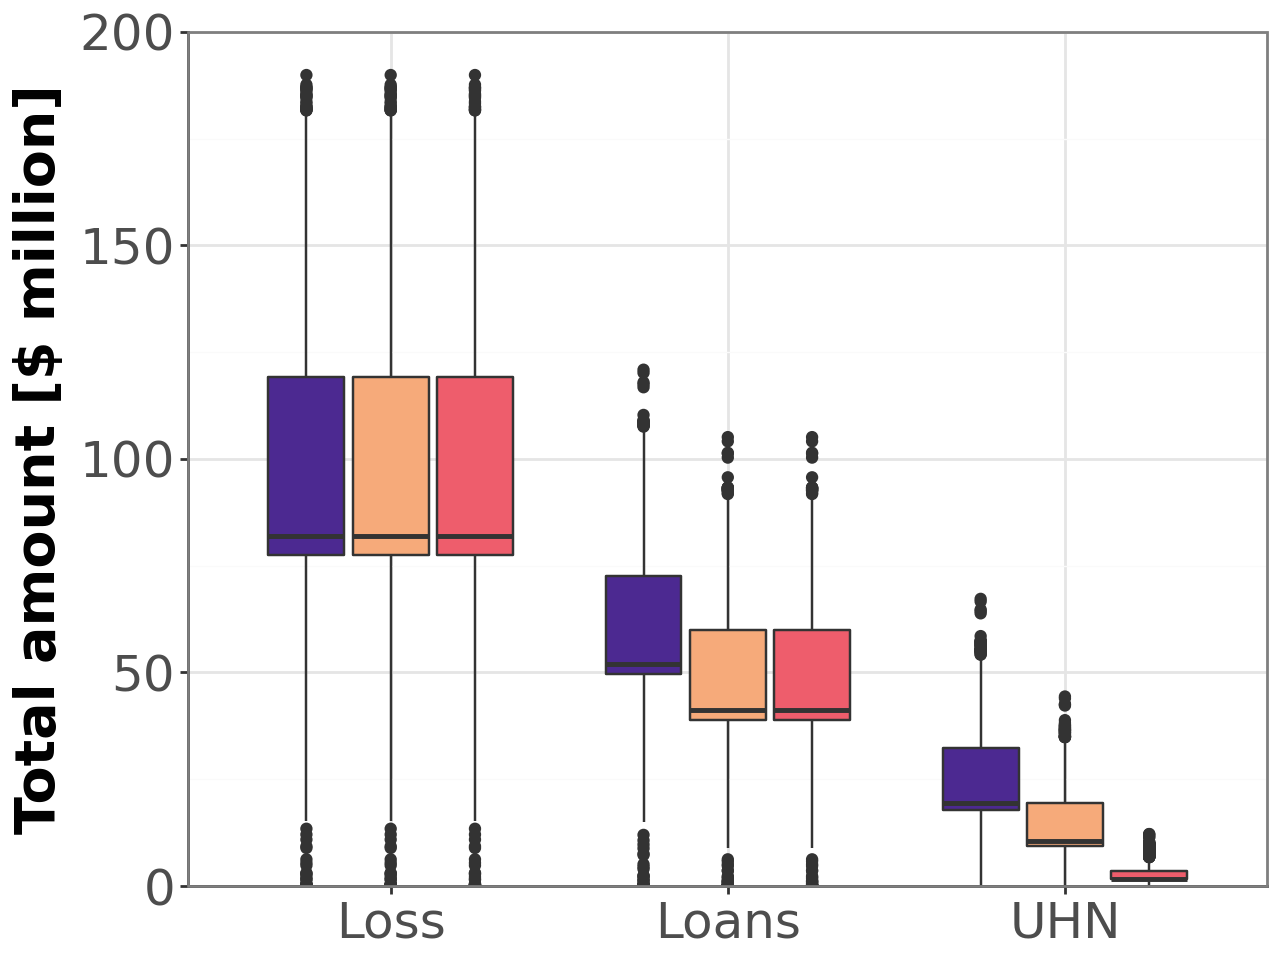

In [302]:
df_Financing_ND['Tag'] = 'No'
df_Financing_DD['Tag'] = 'Yes'
df_Financing_CD['Tag'] = 'Yes + CDBGDR'

df_Financing = pd.concat([df_Financing_ND,df_Financing_DD,df_Financing_CD],ignore_index=True)

df_Financing_long = pd.melt(df_Financing,id_vars='Tag')

df_Financing_long['value'] = df_Financing_long['value'].divide(10**6)

df_Financing_long['variable'] = pd.Categorical(df_Financing_long['variable'] ,
                      categories=['Loss','Loans','UHN'],
                      ordered=True)

plot_base = ggplot(df_Financing_long,aes(x='variable',y='value',fill='Tag')) + geom_boxplot()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=18),
        axis_title=element_text(size=20,face="bold"),
        axis_text_x = element_text(angle = 0, hjust=2),
        legend_position = (0.84,0.82),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        guides(fill=False)+\
        scale_fill_manual(values=[color_sunset_1,color_sunset_5,color_sunset_3]) +\
        scale_y_continuous(name = 'Total amount [$ million]',expand=[0,0],limits=[0,200]) +\
        scale_x_discrete(name = '')

ggsave(plot_clean, filename = scenario + 'LoanLossUHN.pdf', path = data_dir)
df_Financing_long.to_csv(main_dir + 'df_LossLoanUHN_' + scenario + '.txt',index=False)
plot_clean

# Consumption gain - Household

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/3408981548.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/3408981548.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning:

Filename: My Drive/Research/2022_FloodsEPA/Results/2050_100_2/2050_100_2Consumpt

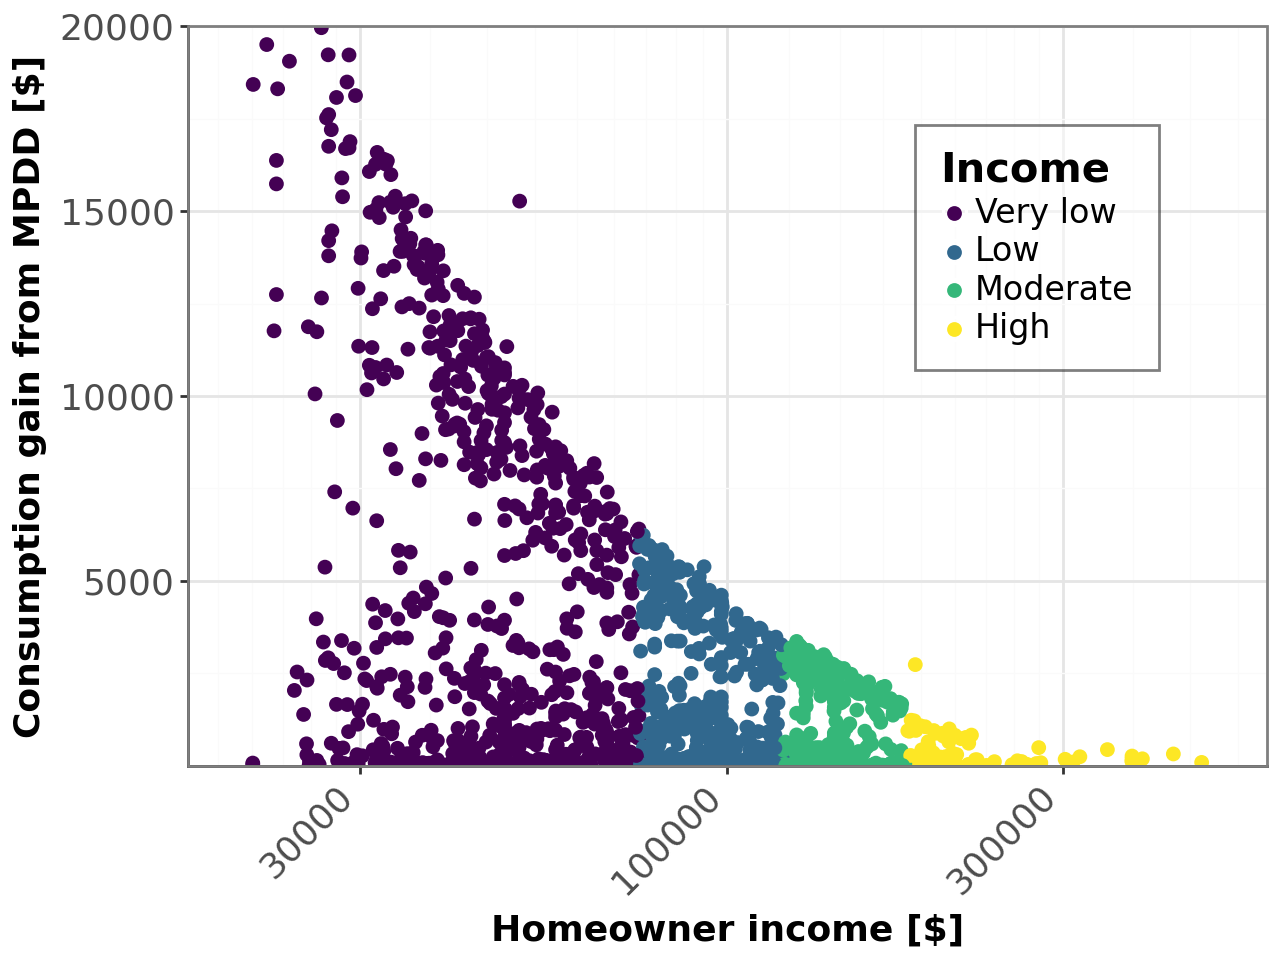

In [294]:
df_ND['Mean'] = df_ND.copy().replace(np.nan,0).loc[:,'S0':'S999'].mean(axis=1)
df_DD['Mean'] = df_DD.copy().replace(np.nan,0).loc[:,'S0':'S999'].mean(axis=1)
df['DeltaW'] = df_ND['Mean'] - df_DD['Mean']
df = df[df['Income']<500000].copy()
plot_base = ggplot(df,aes(x='Income',y='DeltaW',color='Tag')) + geom_point(size=2)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        legend_position = (0.87,0.8),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(color='Income')+\
        scale_y_continuous(name = 'Consumption gain from MPDD [$]',expand=[0,0],limits=[1,20000]) +\
        scale_x_log10(name = 'Homeowner income [$]')
ggsave(plot_clean, filename = scenario + 'ConsumptionGain.pdf', path = data_dir)
plot_clean

# Consumption loss - group

In [295]:
df1 = getConsumptionReduction(df_ND)
df1['Tag'] = 'No'

df2 = getConsumptionReduction(df_DD)
df2['Tag'] = 'Yes'

df3 = getConsumptionReduction(df_CD)
df3['Tag'] = 'Yes + CDBGDR'

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/3612887857.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/3612887857.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/lh/nl6lh2b561dccl267b3w2hzh0000gn/T/ipykernel_8873/3612887857.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning:

Saving 6 x 4.5 in image.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning:

Filename: My Drive/Research/2022_FloodsEPA/Results/2050_100_2/2050_100_2ConsumptionLoss.pdf

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning:

stat_boxplot : Removed 186 rows containing non-finite values.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning:

stat_boxplot : Removed 186 rows containing non-finite values.



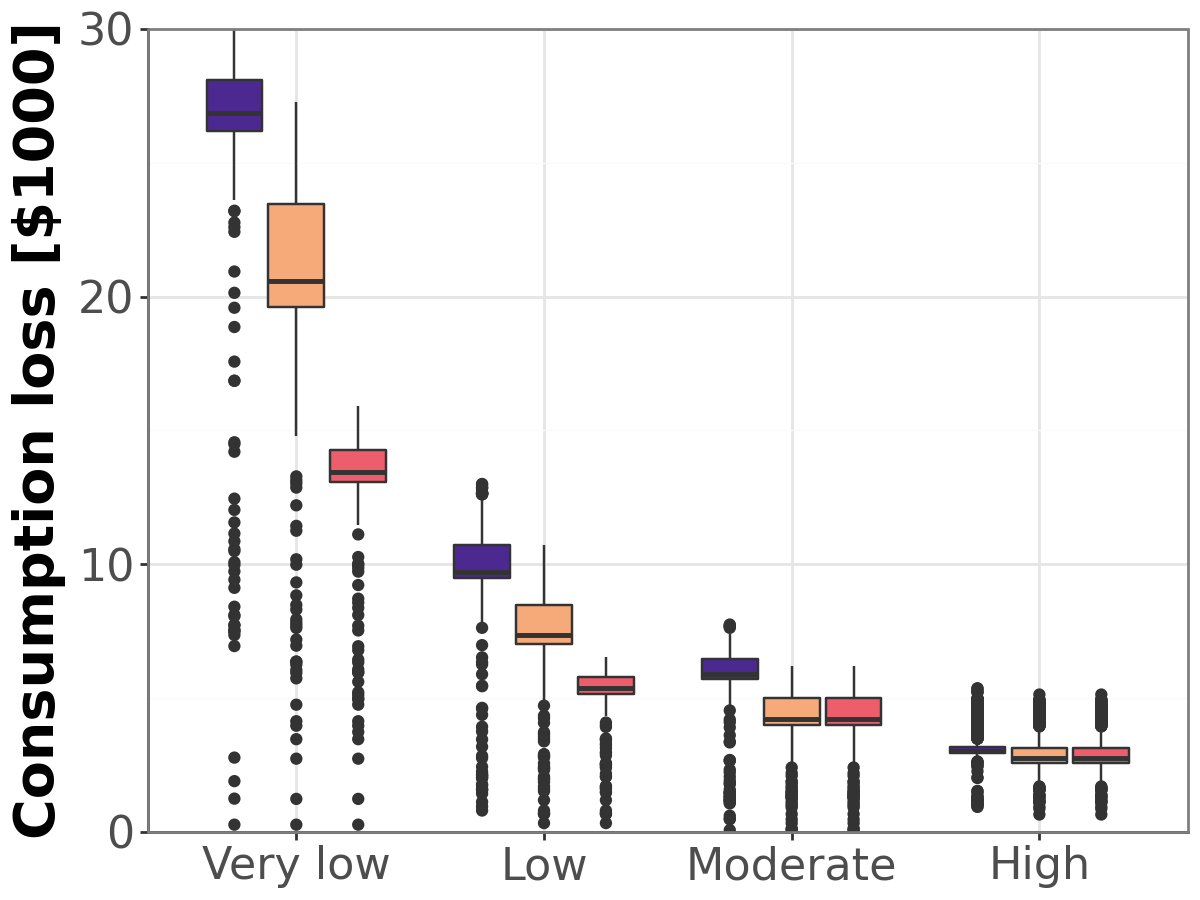

In [296]:
df = pd.concat([df1,df2,df3],ignore_index=True)

df_long = pd.melt(df,id_vars='Tag')

df_long['variable'] = pd.Categorical(df_long['variable'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df_long['Tag'] = pd.Categorical(df_long['Tag'] ,
                      categories=['No','Yes','Yes + CDBGDR'],
                      ordered=True)

plot_base = ggplot(df_long,aes(x='variable',y='value/1000',fill='Tag')) + geom_boxplot()

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=16),
        axis_title=element_text(size=20,face="bold"),
        axis_text_x = element_text(angle = 0, hjust=2),
        legend_position = (0.84,0.82),
        legend_box_margin=8,
        legend_title=element_text(size=15,face='bold'),
        legend_key=element_rect(color = 'white'),
        legend_key_width=10,
        legend_key_size=10,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        guides(fill=False)+\
        labs(fill='Declaration')+\
        theme(figure_size=(6,4.5)) +\
        scale_fill_manual(values=[color_sunset_1,color_sunset_5,color_sunset_3]) +\
        scale_y_continuous(name = 'Consumption loss [$1000]',expand=[0,0],limits=[0,30]) +\
        scale_x_discrete(name = '')

ggsave(plot_clean, filename = scenario + 'ConsumptionLoss.pdf', path = data_dir)
df_long.to_csv(data_dir + 'df_Consumption.txt',index=False)

plot_clean

# Financing by source

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning:

Filename: My Drive/Research/2022_FloodsEPA/Results/2050_100_2/2050_100_2BreakdownND.pdf



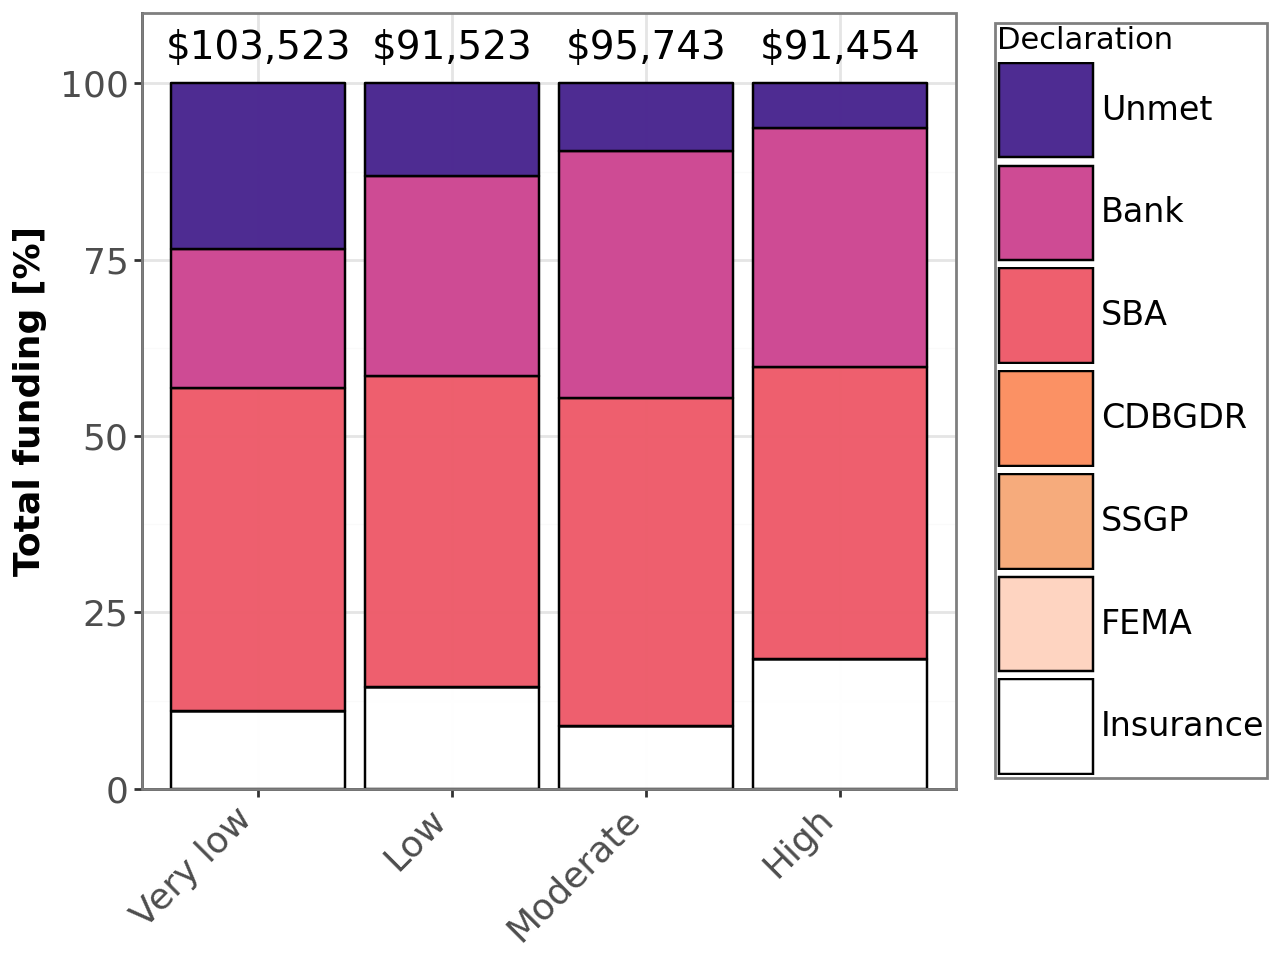

In [297]:
df_summary = df_summary_ND.copy()

df_summary = df_summary[df_summary['Loss']>0].reset_index(drop=True)
df_summary['Insurance'] = df_summary['Insurance'] / df_summary['Loss']
df_summary['FEMA'] = df_summary['FEMA'] / df_summary['Loss']
df_summary['SBA'] = df_summary['SBA'] / df_summary['Loss']
df_summary['SSGP'] = df_summary['SSGP'] / df_summary['Loss']
df_summary['Bank'] = df_summary['Bank'] / df_summary['Loss']
df_summary['CDBGDR'] = df_summary['CDBGDR'] / df_summary['Loss']
df_summary['Unmet'] = df_summary['Unmet'] / df_summary['Loss']

df_bars = df_summary.groupby(by='Tag').mean().reset_index(drop=False)
theLosses = df_bars['Loss']
df_bars = df_bars.drop('Loss',axis=1)

df_bars_long = pd.melt(df_bars,id_vars='Tag')

df_bars_long['Tag'] = pd.Categorical(df_bars_long['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

# df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
#                       categories=['Unmet','CDBGDR','Bank','SSGP','SBA','FEMA','Insurance'],
#                       ordered=True)

df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
                      categories=['Unmet','Bank','SBA','CDBGDR','SSGP','FEMA','Insurance'],
                      ordered=True)

df_bars_long['value'] = df_bars_long['value'].multiply(100)

plot_base = ggplot(df_bars_long,aes(x='Tag',y='value',fill='variable'))+\
        geom_col(position='stack',color='black',alpha=0.99)+\
        annotate('text', x=1, y = 105, label=f'${int(theLosses[0]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=2, y = 105, label=f'${int(theLosses[1]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=3, y = 105, label=f'${int(theLosses[2]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=4, y = 105, label=f'${int(theLosses[3]):,}',size=14,color='black',angle=0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        #legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_fill_manual(values=[color_sunset_1,color_sunset_2,color_sunset_3,color_sunset_4,color_sunset_5,'#fed4c1','white'])+\
        scale_y_continuous(name = 'Total funding [%]',expand=[0,0],limits=[0,110]) +\
        scale_x_discrete(name = '')
ggsave(plot_clean, filename = scenario + 'BreakdownND.pdf', path = data_dir)
plot_clean

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning:

Filename: My Drive/Research/2022_FloodsEPA/Results/2050_100_2/2050_100_2BreakdownND.pdf



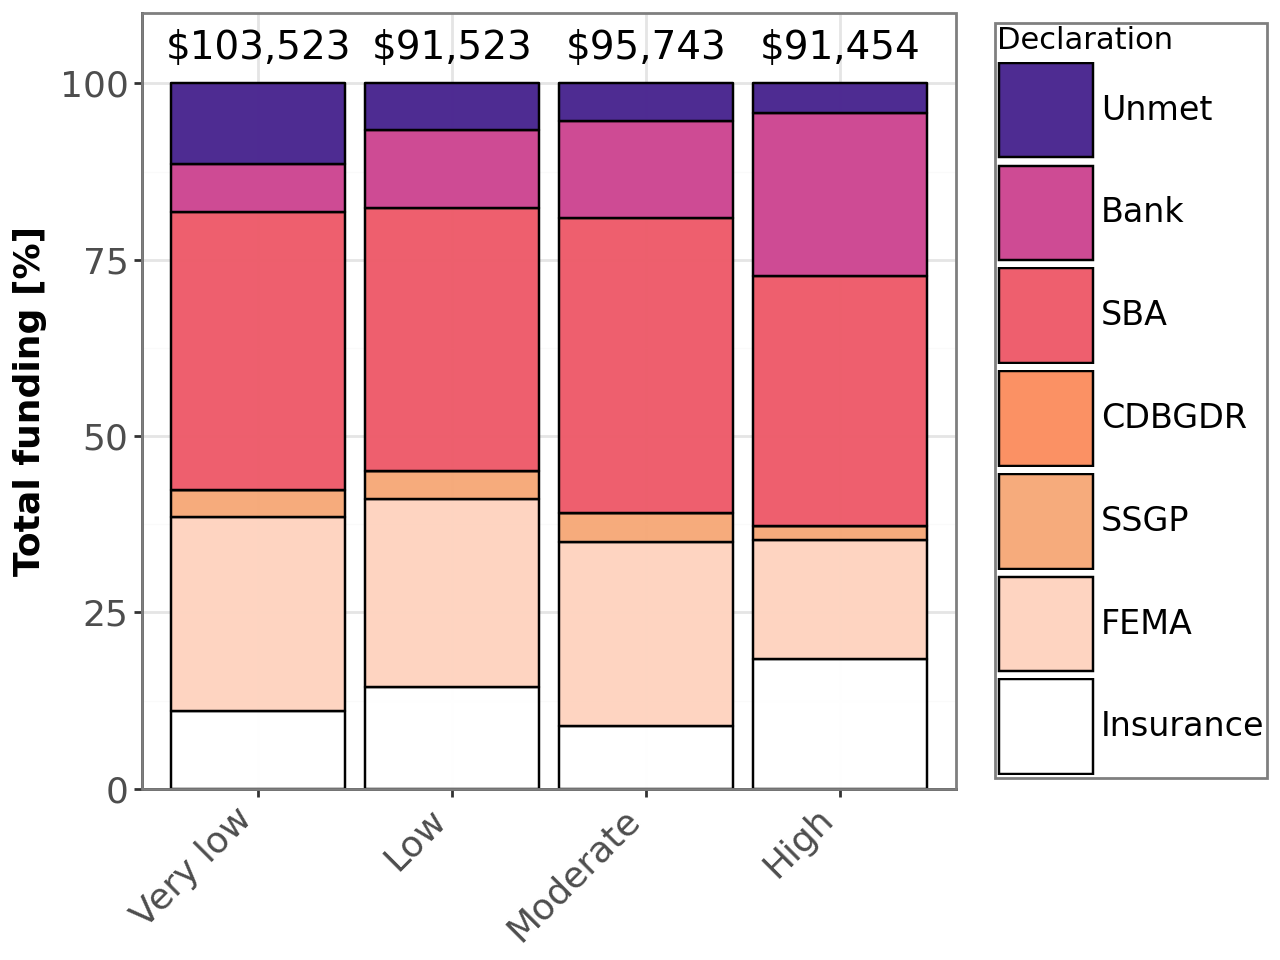

In [298]:
df_summary = df_summary_DD.copy()

df_summary = df_summary[df_summary['Loss']>0].reset_index(drop=True)
df_summary['Insurance'] = df_summary['Insurance'] / df_summary['Loss']
df_summary['FEMA'] = df_summary['FEMA'] / df_summary['Loss']
df_summary['SBA'] = df_summary['SBA'] / df_summary['Loss']
df_summary['SSGP'] = df_summary['SSGP'] / df_summary['Loss']
df_summary['Bank'] = df_summary['Bank'] / df_summary['Loss']
df_summary['CDBGDR'] = df_summary['CDBGDR'] / df_summary['Loss']
df_summary['Unmet'] = df_summary['Unmet'] / df_summary['Loss']

df_bars = df_summary.groupby(by='Tag').mean().reset_index(drop=False)
theLosses = df_bars['Loss']
df_bars = df_bars.drop('Loss',axis=1)

df_bars_long = pd.melt(df_bars,id_vars='Tag')

df_bars_long['Tag'] = pd.Categorical(df_bars_long['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

# df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
#                       categories=['Unmet','CDBGDR','Bank','SSGP','SBA','FEMA','Insurance'],
#                       ordered=True)

df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
                      categories=['Unmet','Bank','SBA','CDBGDR','SSGP','FEMA','Insurance'],
                      ordered=True)

df_bars_long['value'] = df_bars_long['value'].multiply(100)

plot_base = ggplot(df_bars_long,aes(x='Tag',y='value',fill='variable'))+\
        geom_col(position='stack',color='black',alpha=0.99)+\
        annotate('text', x=1, y = 105, label=f'${int(theLosses[0]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=2, y = 105, label=f'${int(theLosses[1]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=3, y = 105, label=f'${int(theLosses[2]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=4, y = 105, label=f'${int(theLosses[3]):,}',size=14,color='black',angle=0)
plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        #legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_fill_manual(values=[color_sunset_1,color_sunset_2,color_sunset_3,color_sunset_4,color_sunset_5,'#fed4c1','white'])+\
        scale_y_continuous(name = 'Total funding [%]',expand=[0,0],limits=[0,110]) +\
        scale_x_discrete(name = '')
ggsave(plot_clean, filename = scenario + 'BreakdownND.pdf', path = data_dir)
plot_clean

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:604: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:605: PlotnineWarning:

Filename: My Drive/Research/2022_FloodsEPA/Results/2050_100_2/2050_100_2BreakdownND.pdf

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning:

position_stack : Removed 1 rows containing missing values.

/opt/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:344: PlotnineWarning:

position_stack : Removed 1 rows containing missing values.



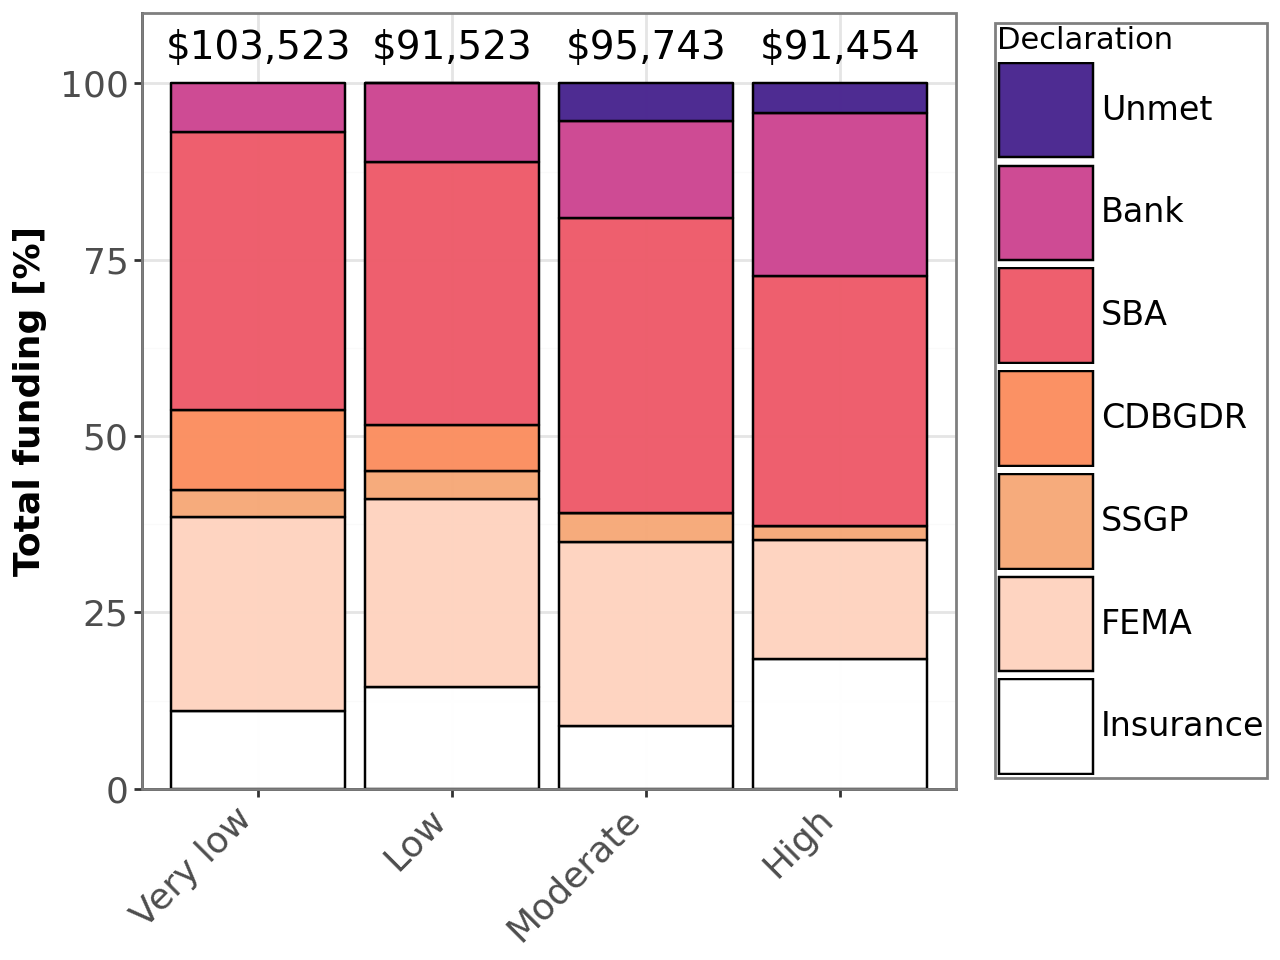

In [299]:
df_summary = df_summary_CD.copy()

df_summary = df_summary[df_summary['Loss']>0].reset_index(drop=True)
df_summary['Insurance'] = df_summary['Insurance'] / df_summary['Loss']
df_summary['FEMA'] = df_summary['FEMA'] / df_summary['Loss']
df_summary['SBA'] = df_summary['SBA'] / df_summary['Loss']
df_summary['SSGP'] = df_summary['SSGP'] / df_summary['Loss']
df_summary['Bank'] = df_summary['Bank'] / df_summary['Loss']
df_summary['CDBGDR'] = df_summary['CDBGDR'] / df_summary['Loss']
df_summary['Unmet'] = df_summary['Unmet'] / df_summary['Loss']

df_bars = df_summary.groupby(by='Tag').mean().reset_index(drop=False)
theLosses = df_bars['Loss']
df_bars = df_bars.drop('Loss',axis=1)

df_bars_long = pd.melt(df_bars,id_vars='Tag')

df_bars_long['Tag'] = pd.Categorical(df_bars_long['Tag'] ,
                      categories=['Very low','Low','Moderate','High'],
                      ordered=True)

df_bars_long['variable'] = pd.Categorical(df_bars_long['variable'] ,
                      categories=['Unmet','Bank','SBA','CDBGDR','SSGP','FEMA','Insurance'],
                      ordered=True)

df_bars_long['value'] = df_bars_long['value'].multiply(100)

plot_base = ggplot(df_bars_long,aes(x='Tag',y='value',fill='variable'))+\
        geom_col(position='stack',color='black',alpha=0.99)+\
        annotate('text', x=1, y = 105, label=f'${int(theLosses[0]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=2, y = 105, label=f'${int(theLosses[1]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=3, y = 105, label=f'${int(theLosses[2]):,}',size=14,color='black',angle=0)+\
        annotate('text', x=4, y = 105, label=f'${int(theLosses[3]):,}',size=14,color='black',angle=0)

plot_clean = plot_base + theme_bw() +\
        theme(
        axis_line=element_line(size=1),
        axis_text=element_text(size=13),
        axis_title=element_text(size=13,face="bold"),
        axis_text_x = element_text(angle = 45, hjust=1),
        #legend_position = (0.72,0.73),
        legend_key=element_rect(color = 'white'),
        legend_key_width=35,
        legend_text=element_text(size=12),
        legend_direction = 'vertical',
        legend_background = element_rect(colour = 'black',alpha=0.5),
        ) +\
        labs(fill='Declaration')+\
        scale_fill_manual(values=[color_sunset_1,color_sunset_2,color_sunset_3,color_sunset_4,color_sunset_5,'#fed4c1','white'])+\
        scale_y_continuous(name = 'Total funding [%]',expand=[0,0],limits=[0,110]) +\
        scale_x_discrete(name = '')
ggsave(plot_clean, filename = scenario + 'BreakdownND.pdf', path = data_dir)
plot_clean

In [300]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

# Generational impact




---



---



In [ ]:
df_20_ND = pd.read_csv(main_dir + 'df_Exceedance_20_ND.txt',index_col=None)
df_20_DD = pd.read_csv(main_dir + 'df_Exceedance_20_DD.txt',index_col=None)
df_20_CD = pd.read_csv(main_dir + 'df_Exceedance_20_CD.txt',index_col=None)

In [ ]:
def getGenerationImpact(nyears = 30, nrep = 50):

    df_PD_Effect = pd.DataFrame()
    colnames = df_Debt_ND.columns
    df_futures_ND = pd.DataFrame(columns=['R'+str(i) for i in range(nrep)])
    df_futures_DD = pd.DataFrame(columns=['R'+str(i) for i in range(nrep)])
    df_futures_CD = pd.DataFrame(columns=['R'+str(i) for i in range(nrep)])

    # Create nrep potential outcomes for year n
    for r in range(nrep):
        # Randomly select one flood map #
        col = rng.choice(a=colnames)
        df_debts_ND = pd.DataFrame(columns=['S'+str(i) for i in range(nyears)])
        df_debts_DD = pd.DataFrame(columns=['S'+str(i) for i in range(nyears)])
        df_debts_CD = pd.DataFrame(columns=['S'+str(i) for i in range(nyears)])

        for n in range(nyears):

            # Check if there was a storm this year
            if rng.random() < 0.01:

                # Determine if the flood map of number # will be picked between those with SLR or not
                theSLRFlag = 1 if rng.random() < n/nyears else 0

                # If from the SLR maps
                if theSLRFlag == 1:
                    df_debts_ND['S'+str(n)] = df_debt_2050_100_ND[col]
                    df_debts_DD['S'+str(n)] = df_debt_2050_100_DD[col]
                    df_debts_CD['S'+str(n)] = df_debt_2050_100_CD[col]

                # If not from SLR maps
                else:
                    df_debts_ND['S'+str(n)] = df_debt_2020_100_ND[col]
                    df_debts_DD['S'+str(n)] = df_debt_2020_100_DD[col]
                    df_debts_CD['S'+str(n)] = df_debt_2020_100_CD[col]

            else:
                df_debts_ND['S'+str(n)] = [0] * df_blds.shape[0]
                df_debts_DD['S'+str(n)] = [0] * df_blds.shape[0]
                df_debts_CD['S'+str(n)] = [0] * df_blds.shape[0]

        # set the mean from nrep outcomes for year n as the estimated debt for year n
        df_futures_ND['R'+str(r)] = df_debts_ND.sum(axis=1)
        df_futures_DD['R'+str(r)] = df_debts_DD.sum(axis=1)
        df_futures_CD['R'+str(r)] = df_debts_CD.sum(axis=1)


    return df_futures_ND, df_futures_DD, df_futures_CD


def getExceedanceCurves(df_futures,nrep=1):
    df_plot = pd.DataFrame()
    df_plot['data'] = df_futures.sum()
    df_plot = df_plot.reset_index(drop=True)


    df_futures['Tag'] = df_blds['IncomeTag']
    df_futures['Tag'] = pd.Categorical(df_futures['Tag'] ,
                          categories=['Very low','Low','Moderate','High'],
                          ordered=True)
    df_futures_grp = df_futures.replace(0,np.nan).groupby(by='Tag').mean().reset_index()


    df_plot = pd.DataFrame()
    df_plot['Threshold'] = list(range(0,50000,1000))
    df_plot['Very low'] = [0] * df_plot.shape[0]
    df_plot['Low'] = [0] * df_plot.shape[0]
    df_plot['Moderate'] = [0] * df_plot.shape[0]
    df_plot['High'] = [0] * df_plot.shape[0]


    for i in range(df_plot.shape[0]):
        df_plot.loc[i,'Very low'] = np.sum(df_futures_grp[df_futures_grp['Tag'] == 'Very low'].reset_index().loc[:,'R0':'R'+str(nrep-1)].transpose() > df_plot.loc[i,'Threshold']).iloc[0]/nrep
        df_plot.loc[i,'Low'] = np.sum(df_futures_grp[df_futures_grp['Tag'] == 'Low'].reset_index().loc[:,'R0':'R'+str(nrep-1)].transpose() > df_plot.loc[i,'Threshold']).iloc[0]/nrep
        df_plot.loc[i,'Moderate'] = np.sum(df_futures_grp[df_futures_grp['Tag'] == 'Moderate'].reset_index().loc[:,'R0':'R'+str(nrep-1)].transpose() > df_plot.loc[i,'Threshold']).iloc[0]/nrep
        df_plot.loc[i,'High'] = np.sum(df_futures_grp[df_futures_grp['Tag'] == 'High'].reset_index().loc[:,'R0':'R'+str(nrep-1)].transpose() > df_plot.loc[i,'Threshold']).iloc[0]/nrep


    return df_plot


In [ ]:
nrep = 100
df_futures_ND, df_futures_DD, df_futures_CD = getGenerationImpact(nyears = 31, nrep = nrep)
df_100_ND = getExceedanceCurves(df_futures_ND, nrep = nrep)
df_100_DD = getExceedanceCurves(df_futures_DD, nrep = nrep)
df_100_CD = getExceedanceCurves(df_futures_CD, nrep = nrep)

# Exceedance storm

In [ ]:
df_20 = pd.DataFrame()
df_20['Threshold'] = df_20_ND['Threshold']
df_20['Very low'] = df_20_ND['Very low']
df_20['Low'] = df_20_ND['Low']
df_20['Moderate'] = df_20_ND['Moderate']
df_20['High'] = df_20_ND['High']

df_20_long = pd.melt(df_20,id_vars=['Threshold'])

plot_base = ggplot(df_20_long,aes(x='Threshold',y='value',color='variable',linetype='variable')) + geom_line(size=1.2)
plot_clean = plot_base + theme_bw() +\
            theme(
            #plot_background=element_rect(fill='gray', alpha=.3),
            #panel_background=element_rect(fill='white', alpha=.2),
            axis_line=element_line(size=1),
            axis_text=element_text(size=13),
            axis_title=element_text(size=13,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            #legend_position = (0.72,0.73),
            legend_key=element_rect(color = 'white'),
            legend_key_width=35,
            legend_text=element_text(size=12),
            legend_direction = 'vertical',
            legend_background = element_rect(colour = 'black',alpha=0.5),
            ) +\
            scale_color_manual(values=['black',vir2,vir3,'orange']) +\
            scale_y_continuous(name = 'Probability of exceedance',limits=[0,0.8], expand=[0,0]) +\
            scale_x_log10(name = 'Estimated debt 2020-2050 [$]',limits=[1000,30000], expand=[0,0])
plot_clean

In [ ]:
df_20 = pd.DataFrame()
df_20['Threshold'] = df_20_DD['Threshold']
df_20['Very low'] = df_20_DD['Very low']
df_20['Low'] = df_20_DD['Low']
df_20['Moderate'] = df_20_DD['Moderate']
df_20['High'] = df_20_DD['High']

df_20_long = pd.melt(df_20,id_vars=['Threshold'])

plot_base = ggplot(df_20_long,aes(x='Threshold',y='value',color='variable',linetype='variable')) + geom_line(size=1.2)
plot_clean = plot_base + theme_bw() +\
            theme(
            #plot_background=element_rect(fill='gray', alpha=.3),
            #panel_background=element_rect(fill='white', alpha=.2),
            axis_line=element_line(size=1),
            axis_text=element_text(size=13),
            axis_title=element_text(size=13,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            #legend_position = (0.72,0.73),
            legend_key=element_rect(color = 'white'),
            legend_key_width=35,
            legend_text=element_text(size=12),
            legend_direction = 'vertical',
            legend_background = element_rect(colour = 'black',alpha=0.5),
            ) +\
            scale_color_manual(values=['black',vir2,vir3,'orange']) +\
            scale_y_continuous(name = 'Probability of exceedance',limits=[0,0.8], expand=[0,0]) +\
            scale_x_log10(name = 'Estimated debt 2020-2050 [$]',limits=[1000,30000], expand=[0,0])
plot_clean

In [ ]:
df_20 = pd.DataFrame()
df_20['Threshold'] = df_20_CD['Threshold']
df_20['Very low'] = df_20_CD['Very low']
df_20['Low'] = df_20_CD['Low']
df_20['Moderate'] = df_20_CD['Moderate']
df_20['High'] = df_20_CD['High']

df_20_long = pd.melt(df_20,id_vars=['Threshold'])

plot_base = ggplot(df_20_long,aes(x='Threshold',y='value',color='variable',linetype='variable')) + geom_line(size=1.2)
plot_clean = plot_base + theme_bw() +\
            theme(
            #plot_background=element_rect(fill='gray', alpha=.3),
            #panel_background=element_rect(fill='white', alpha=.2),
            axis_line=element_line(size=1),
            axis_text=element_text(size=13),
            axis_title=element_text(size=13,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            #legend_position = (0.72,0.73),
            legend_key=element_rect(color = 'white'),
            legend_key_width=35,
            legend_text=element_text(size=12),
            legend_direction = 'vertical',
            legend_background = element_rect(colour = 'black',alpha=0.5),
            ) +\
            scale_color_manual(values=['black',vir2,vir3,'orange']) +\
            scale_y_continuous(name = 'Probability of exceedance',limits=[0,0.8], expand=[0,0]) +\
            scale_x_log10(name = 'Estimated debt 2020-2050 [$]',limits=[1000,30000], expand=[0,0])
plot_clean

In [ ]:
df_100 = pd.DataFrame()
df_100['Threshold'] = df_100_ND['Threshold']
df_100['Very low'] = df_100_ND['Very low']
df_100['Low'] = df_100_ND['Low']
df_100['Moderate'] = df_100_ND['Moderate']
df_100['High'] = df_100_ND['High']

df_100_long = pd.melt(df_100,id_vars=['Threshold'])

plot_base = ggplot(df_100_long,aes(x='Threshold',y='value',color='variable',linetype='variable')) + geom_line(size=1.2)
plot_clean = plot_base + theme_bw() +\
            theme(
            #plot_background=element_rect(fill='gray', alpha=.3),
            #panel_background=element_rect(fill='white', alpha=.2),
            axis_line=element_line(size=1),
            axis_text=element_text(size=13),
            axis_title=element_text(size=13,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            #legend_position = (0.72,0.73),
            legend_key=element_rect(color = 'white'),
            legend_key_width=35,
            legend_text=element_text(size=12),
            legend_direction = 'vertical',
            legend_background = element_rect(colour = 'black',alpha=0.5),
            ) +\
            scale_color_manual(values=['black',vir2,vir3,'orange']) +\
            scale_y_continuous(name = 'Probability of exceedance',limits=[0,0.8], expand=[0,0]) +\
            scale_x_log10(name = 'Estimated debt 2020-2050 [$]',limits=[1000,30000], expand=[0,0])
plot_clean

In [ ]:
df_100 = pd.DataFrame()
df_100['Threshold'] = df_100_DD['Threshold']
df_100['Very low'] = df_100_DD['Very low']
df_100['Low'] = df_100_DD['Low']
df_100['Moderate'] = df_100_DD['Moderate']
df_100['High'] = df_100_DD['High']

df_100_long = pd.melt(df_100,id_vars=['Threshold'])

plot_base = ggplot(df_100_long,aes(x='Threshold',y='value',color='variable',linetype='variable')) + geom_line(size=1.2)
plot_clean = plot_base + theme_bw() +\
            theme(
            #plot_background=element_rect(fill='gray', alpha=.3),
            #panel_background=element_rect(fill='white', alpha=.2),
            axis_line=element_line(size=1),
            axis_text=element_text(size=13),
            axis_title=element_text(size=13,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            #legend_position = (0.72,0.73),
            legend_key=element_rect(color = 'white'),
            legend_key_width=35,
            legend_text=element_text(size=12),
            legend_direction = 'vertical',
            legend_background = element_rect(colour = 'black',alpha=0.5),
            ) +\
            scale_color_manual(values=['black',vir2,vir3,'orange']) +\
            scale_y_continuous(name = 'Probability of exceedance',limits=[0,0.8], expand=[0,0]) +\
            scale_x_log10(name = 'Estimated debt 2020-2050 [$]',limits=[1000,30000], expand=[0,0])
plot_clean

In [ ]:
df_100 = pd.DataFrame()
df_100['Threshold'] = df_100_CD['Threshold']
df_100['Very low'] = df_100_CD['Very low']
df_100['Low'] = df_100_CD['Low']
df_100['Moderate'] = df_100_CD['Moderate']
df_100['High'] = df_100_CD['High']

df_100_long = pd.melt(df_100,id_vars=['Threshold'])

plot_base = ggplot(df_100_long,aes(x='Threshold',y='value',color='variable',linetype='variable')) + geom_line(size=1.2)
plot_clean = plot_base + theme_bw() +\
            theme(
            #plot_background=element_rect(fill='gray', alpha=.3),
            #panel_background=element_rect(fill='white', alpha=.2),
            axis_line=element_line(size=1),
            axis_text=element_text(size=13),
            axis_title=element_text(size=13,face="bold"),
            axis_text_x = element_text(angle = 45, hjust=1),
            #legend_position = (0.72,0.73),
            legend_key=element_rect(color = 'white'),
            legend_key_width=35,
            legend_text=element_text(size=12),
            legend_direction = 'vertical',
            legend_background = element_rect(colour = 'black',alpha=0.5),
            ) +\
            scale_color_manual(values=['black',vir2,vir3,'orange']) +\
            scale_y_continuous(name = 'Probability of exceedance',limits=[0,0.8], expand=[0,0]) +\
            scale_x_log10(name = 'Estimated debt 2020-2050 [$]',limits=[1000,30000], expand=[0,0])
plot_clean